In [2]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_model = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)

In [27]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(32)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [28]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics=[keras.metrics.BinaryAccuracy()]
    )

In [29]:
datagen = ImageDataGenerator(  
    featurewise_center=True,   
    samplewise_center=True, 
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    horizontal_flip=True, 
    vertical_flip=False
    ) 

In [30]:

train_it = datagen.flow_from_directory('cars/train/', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode='binary', 
                                       batch_size=8)

test_it = datagen.flow_from_directory('cars/validate/', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 248 images belonging to 2 classes.
Found 76 images belonging to 2 classes.


In [31]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_binary_accuracy')>0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [32]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .0001), 
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [44]:
history = model.fit(train_it,  
validation_data=test_it,  
epochs=50,
callbacks=[callbacks]
)

C:\anaconda\envs\ml\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Epoch 1/50
31/31 [==============================] - 120s 4s/step - loss: 0.1617 - binary_accuracy: 0.9476 - val_loss: 1.7129 - val_binary_accuracy: 0.6316
Epoch 2/50
31/31 [==============================] - 120s 4s/step - loss: 0.1556 - binary_accuracy: 0.9476 - val_loss: 0.3568 - val_binary_accuracy: 0.8947
Epoch 3/50
31/31 [==============================] - 119s 4s/step - loss: 0.2915 - binary_accuracy: 0.9113 - val_loss: 0.7544 - val_binary_accuracy: 0.6974
Epoch 4/50
31/31 [==============================] - 118s 4s/step - loss: 0.2244 - binary_accuracy: 0.9274 - val_loss: 0.3800 - val_binary_accuracy: 0.9079
Epoch 5/50
31/31 [==============================] - 118s 4s/step - loss: 0.0

<AxesSubplot:>

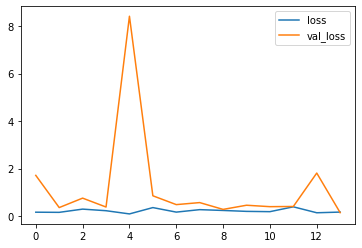

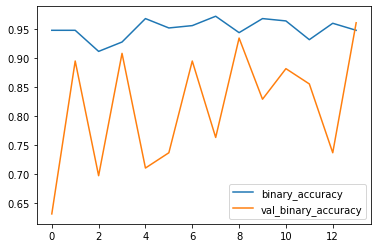

In [45]:

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [46]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    print(preds)
    if preds[0] < 0:
        print("This vehicle is totally wrecked!")
    else:
        print("Fraud attempt! This car is not totally wrecked")

[[-6.6013346]]
Cette voiture est épave!


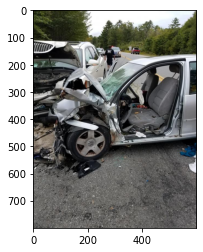

In [62]:
make_predictions('cars/test/4.jpg')

[[-8.974762]]
Cette voiture est épave!


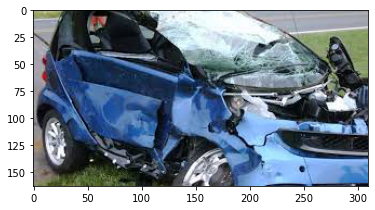

In [63]:
make_predictions('cars/test/0016.jpg')

[[-6.073244]]
Cette voiture est épave!


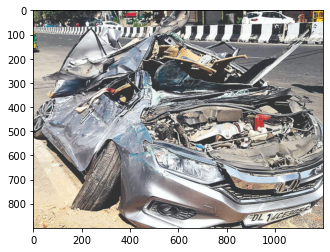

In [64]:
make_predictions('cars/test/60.jpg')

[[104.368935]]
Tentative de fraude! Cette voiture n'est pas épave.


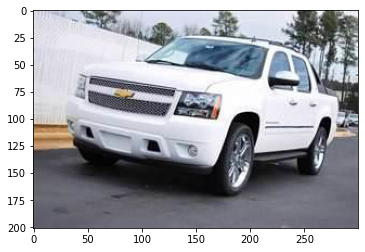

In [65]:
make_predictions('cars/test/0240.jpg')

[[146.74422]]
Tentative de fraude! Cette voiture n'est pas épave.


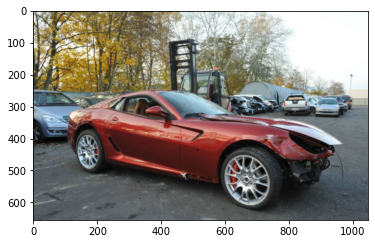

In [66]:
make_predictions('cars/test/8.jpg')

[[6.154258]]
Tentative de fraude! Cette voiture n'est pas épave.


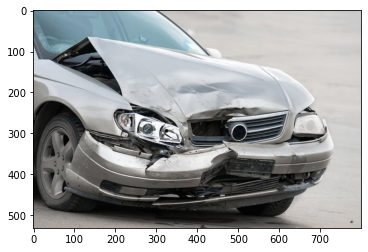

In [67]:
make_predictions('cars/test/2.jpg')

In [61]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [3]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [4]:
loaded_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .0001), 
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [6]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions_loaded_model(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = loaded_model.predict(image)
    print(preds)
    if preds[0] < 0:
        print("Cette voiture est épave!")
    else:
        print("Tentative de fraude! Cette voiture n'est pas épave.")

[[6.154258]]
Tentative de fraude! Cette voiture n'est pas épave.


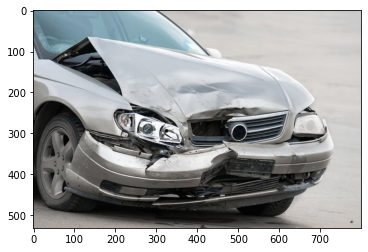

In [7]:
make_predictions_loaded_model('cars/test/2.jpg')